In [1]:
from Nowack_Lab.Utilities import multih5
import numpy as np
from os.path import basename
import time
import yaml

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Current experimental save paths:
D:\data\Orenstein\experiments\2022-06-20_Orenstein-saving-test
Z:\data\DESKTOP-6212UG8\experiments\2022-06-20_Orenstein-saving-test
Current experiment: 2022-06-20_Orenstein-saving-test-SAMBA-ok
New experiment? y/(n): 


## Measurement and saving

In [2]:
import Nowack_Lab.Instruments.keithley as keithley
import Nowack_Lab.Instruments.hp8753d as hp8753d
keithley2450 = keithley.Keithley2450()
vna = hp8753d.VNA8753D()
instruments = {
    'keithley': keithley2450,
    'vna': vna,
}

In [14]:
# For now, metadata must not have nested objects
metadata = yaml.safe_load('''
name: Blue coax loss
author name: Alex Striff
author email: abs299@cornell.edu
description: >
  Sweep of $S_{21}$ in source power and frequency for blue coax.
  
  Connections:
    port1-coax(male)-coax(male)-SMA(female-female)-SMA(male-male)-port2
  
  The extra connectors on port 2 were added because port 2 of the VNA is
  slightly damaged and wiggly from use over the years.
format: >
  Dataset dimension label <x> is the sweep of scales/<x>.
  Units are given in the 'unit' attribute.
''')

initial_configuration = yaml.safe_load('''
keithley:
  source: 'I'
  Iout_range: 1.0e-3 #A
  V_compliance: 21.0
  output: 'on'
  Iout: 0.0e-3 #A
vna:
  networkparam: 'S21'
  power: -40.0 #dBm
  power_range_auto: False
  minfreq: 1.0e+9 #Hz
  maxfreq: 3.0e+9 #Hz
  sweeptime: 1.0 #s
  sweepmode: 'LIN'
  numpoints: 1601
  averaging_state: 0 #off
  IF_bandwidth: 3.0e+3 #Hz (wide so we detect resonances)
''')

In [15]:
for instrument, settings in initial_configuration.items():
    i = instruments[instrument]
    for k, v in settings.items():
        setattr(i, k, v)

There is sometimes a jump on the lowest frequency, so do one throwaway sweep before taking data.

In [16]:
vna.source_power_on = True
vna.write('SING')

In [19]:
def add_scale(f, name, unit, x):
    path = 'scales/{}'.format(name)
    f[path] = x
    f[path].attrs['unit'] = unit
    return x

In [20]:
filenames = []
with multih5.Files('blue-coax-loss', 'w',
                   libver = 'latest',
                  ) as fs:
    for f in fs:
        filenames.append(f.filename)
        
        # Write metadata
        for k, v in metadata.items():
            f.attrs[k] = v
        
    # Initial instrument states
    for name, instrument in instruments.items():
        for k, v in instrument.__getstate__().items():
            for f in fs:
                f['instruments/{}/{}'.format(name, k)] = v

    # Keithley 2450 needs some time, or else setting current doesn't work
    time.sleep(0.1) #s

    # Sweep scales
    powers, freqs = scales = [
#         ('Field coil current', 'A', np.arange(0, 0.3e-3, 0.1e-3)),
        ('Source power', 'dBm', np.linspace(
            *vna.range_powers[vna.power_range],
            num = 11, # arbitrary
        )),
        ('Frequency', 'Hz', vna.frequencies()),
    ]
    for f in fs:
        for scale in scales:
            add_scale(f, *scale)
    shape = tuple(len(scale[2]) for scale in scales)

    # Sweep variables
    for f in fs:
        re = f.create_dataset('S21_re', shape)
        re.attrs['description'] = '$\Re S_{21}$'
        re.attrs['unit'] = 'U'
        
        im = f.create_dataset('S21_im', shape)
        im.attrs['description'] = '$\Im S_{21}$'
        im.attrs['unit'] = 'U'
        
        datasets = [re, im]
        for x in datasets:
            for i, scale in enumerate(scales):
                x.dims[i].label = basename(scale[0])
            
        f.swmr_mode = True # Now we should only modify data

#     for iI, I in enumerate(Is[2]):
#         instruments['keithley'].Iout = I
    for iP, P in enumerate(powers[2]):
        instruments['vna'].power = P
        # Freq sweep returns the sweep array
        S21_reim = instruments['vna'].reim()
        for f in fs:
            f['S21_re'][iP,:] = S21_reim[0,:]
            f['S21_im'][iP,:] = S21_reim[1,:]

D:\data\Orenstein\experiments\2022-06-20_Orenstein-saving-test\2022-06-23_170025_blue-coax-loss.hdf5
Z:\data\DESKTOP-6212UG8\experiments\2022-06-20_Orenstein-saving-test\2022-06-23_170025_blue-coax-loss.hdf5


## Plotting

In [21]:
import h5py as h5
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pathlib import Path

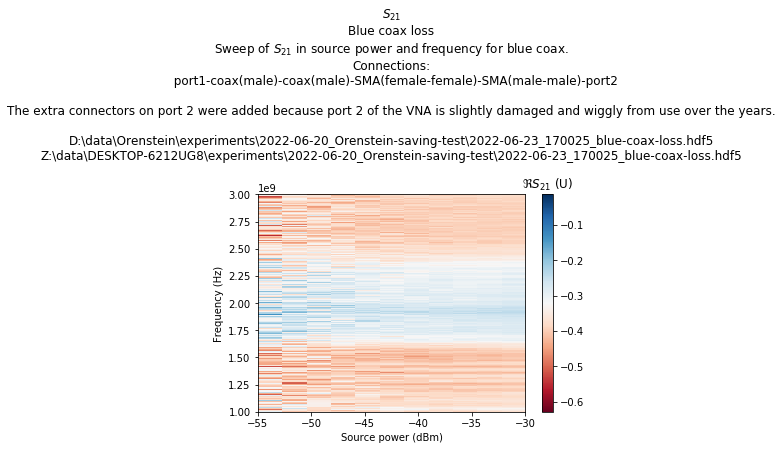

In [28]:
plotfile = filenames[0]
with h5.File(plotfile,
             'r',
             libver = 'latest',
             swmr = True,
            ) as f:
    # Assume 2D data in x
    x, y = f['S21_re'], f['S21_im']
    labels = [d.label for d in x.dims]
    scales = [f['scales/{}'.format(l)] for l in labels]
    scaledata = [s[:] for s in scales]
    scaleunits = [s.attrs['unit'] for s in scales]
    scalelabels = ['{} ({})'.format(l, u) for l, u in zip(labels, scaleunits)]
    
    plt.imshow(np.transpose(10*np.log10(np.sqrt(x[:]**2 + y[:]**2))),
               extent = (
                   scaledata[-2].min(), scaledata[-2].max(),
                   scaledata[-1].min(), scaledata[-1].max(),
               ),
               cmap = cm.RdBu,
               aspect = 'auto',
              )
    plt.title('\n'.join([
        "$S_{21}$",
        f.attrs['name'],
        f.attrs['description'],
        *filenames,
        '',''
    ]))
    plt.xlabel(scalelabels[-2])
    plt.ylabel(scalelabels[-1])
    cb = plt.colorbar()
    cb.ax.set_title('{} ({})'.format(x.attrs['description'], x.attrs['unit']))
    
    for file in filenames:
        plt.savefig(Path(file).with_suffix('.pdf'),
                    dpi = 600,
                    bbox_inches='tight',
                   )
    plt.show()